In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.animation as animation
from drl_grams import *

mpl.rcParams.update({'font.size': 12})
plt.rcParams['axes.axisbelow'] = True
%matplotlib widget
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrkmyc')

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["b", "g", "r", 'k','y' , 'm','tab:orange', 'tab:cyan', 'tab:brown', 'slategrey', 'deeppink' ]) 

# Genetic Algorithms

In the directory `genetic_algorithm_results/` the results obtained using genetic algorithms can be found. Different subdirectories represent different combinations of hyperparameters, a summary of the hyper-parameters and system parameters used to obtain each directory can be accesed by calling the `print_params` function 

In [2]:
directory = 'genetic_algorithm_results/rb_zhang/'

In [3]:
print_ga_params(directory)

Showing parameters for genetic_algorithm_results/rb_zhang/:
╒═══════════════════╤═══════════════════════╤══════════════╕
│ Section           │ Parameter             │ Value        │
╞═══════════════════╪═══════════════════════╪══════════════╡
│ system_parameters │ initial_n             │ 8            │
├───────────────────┼───────────────────────┼──────────────┤
│ system_parameters │ final_n               │ 64           │
├───────────────────┼───────────────────────┼──────────────┤
│ system_parameters │ n_step                │ 4            │
├───────────────────┼───────────────────────┼──────────────┤
│ system_parameters │ dt                    │ 0.15         │
├───────────────────┼───────────────────────┼──────────────┤
│ system_parameters │ b                     │ 100          │
├───────────────────┼───────────────────────┼──────────────┤
│ system_parameters │ speed_fraction        │ None         │
├───────────────────┼───────────────────────┼──────────────┤
│ ga_initialization │ num

Time evolution for different trials and parameters can be studied. Here we study 20 samples obtained using three different fitness functions:
- reward based: emulates RL reward from [1], in the sense that it accumulates over time steps rewarding better fidelity and discounting for each extra step with a reward decay gamma to promote faster transmissions
- natural based: also accumulates over time steps but rewards a transmission that behaves in a similar way to the natural evolution. The *wave* propagates at a similar speed but tries to achieve a higher max probability.
- ipr based: rewards a localized transition, in the sense that it attempts to have a concentrated package

# Effect of different fitness functions

In [4]:
# accede a todas las secuencias
n = 16
ga_sequences = uniformize_data('ga',**{'directory': directory + f'n{n}/', 'n':n})

Text(0, 0.5, 'Transition probability')

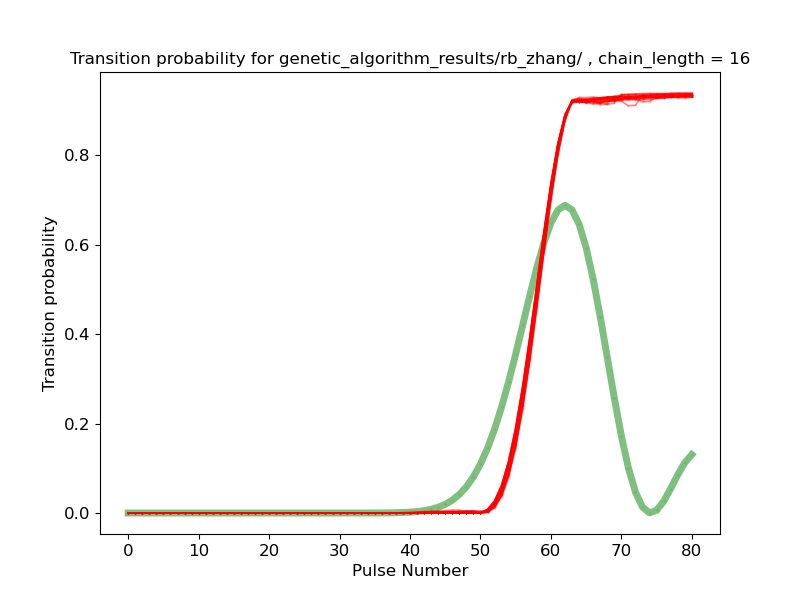

In [8]:
fs  = 12
plt.figure(figsize=(8, 6))
plt.title(f'Transition probability for {directory} , chain_length = {n}', fontsize=fs)
samples = np.arange(0,np.shape(ga_sequences)[0],1)
for sample in samples:
    forced_evol, natural_evol = fid_evolution(ga_sequences[sample][:], 16, dt=0.15, b=100, label="", actions="original", add_natural=True)
    plt.plot(forced_evol, '-o', label=f'GA {sample}', color='red', alpha=0.5, linewidth=1.2, markersize=0.2)

plt.plot(natural_evol, '-o', label='Natural', color='green', alpha=0.5, linewidth=5, markersize=0.2, zorder = -2)
# Mover etiquetas de los ejes al eje principal
plt.xlabel('Pulse Number', fontsize=fs)
plt.ylabel('Transition probability', fontsize=fs)
# Create a personalized legend